In [1]:
#!/usr/bin/env python
%load_ext autoreload
%autoreload 2

import numpy as np, os, sys
from scipy.io import loadmat
from tqdm.notebook import tqdm
def load_challenge_data(filename):


    x = loadmat(filename)
    data = np.asarray(x['val'], dtype=np.float64)

    new_file = filename.replace('.mat','.hea')
    input_header_file = os.path.join(new_file)

    with open(input_header_file,'r') as f:
        header_data=f.readlines()


    return data, header_data


def save_challenge_predictions(output_directory,filename,scores,labels,classes):

    recording = os.path.splitext(filename)[0]
    new_file = filename.replace('.mat','.csv')
    output_file = os.path.join(output_directory,new_file)

    # Include the filename as the recording number
    recording_string = '#{}'.format(recording)
    class_string = ','.join(classes)
    label_string = ','.join(str(i) for i in labels)
    score_string = ','.join(str(i) for i in scores)

    with open(output_file, 'w') as f:
        f.write(recording_string + '\n' + class_string + '\n' + label_string + '\n' + score_string + '\n')

  
# Find unique number of classes  
def get_classes(input_directory,files):

    classes=[]
    for f in files:
        g = f.replace('.mat','.hea')
        input_file = os.path.join(input_directory,g)
        with open(input_file,'r') as f:
            classes += get_classes_from_header(f)

    return sorted(set(classes))

def get_classes_from_header(header_data):
    classes = []
    for lines in header_data:
        if lines.startswith('#Dx'):
            tmp = lines.split(': ')[1].split(',')
            for c in tmp:
                classes.append(c.strip())
    return sorted(classes)

def get_Fs_from_header(header_data):
    fst_line = header_data[0].split(' ')
    return int(fst_line[2])

In [2]:
                        
if __name__ == '__main__':
    
    Datas = []
    Header_datas = []
    Classes = []
    for dataset in range(1,7):
        print('Dataset ', dataset)
        # Parse arguments.
        if len(sys.argv) != 3:
            raise Exception('Include the input and output directories as arguments, e.g., python driver.py input output.')

        input_directory = '../Data/Training{}/'.format(dataset)
        output_directory = '../Output/'

        # Find files.
        input_files = []
        for f in os.listdir(input_directory):
            if os.path.isfile(os.path.join(input_directory, f)) and not f.lower().startswith('.') and f.lower().endswith('mat'):
                input_files.append(f)

        if not os.path.isdir(output_directory):
            os.mkdir(output_directory)

        classes=get_classes(input_directory,input_files)

        num_files = len(input_files)
        datas = []
        header_datas = []
        for i, f in tqdm(enumerate(input_files)):
            #print('    {}/{}...'.format(i+1, num_files), f)
            tmp_input_file = os.path.join(input_directory,f)
            data,header_data = load_challenge_data(tmp_input_file)
            datas.append(data)
            header_datas.append(header_data)

        Datas += datas
        Header_datas += header_datas
        Classes += classes
        print('Done.')

Dataset  1



Done.
Dataset  2



Done.
Dataset  3



Done.
Dataset  4



Done.
Dataset  5



Done.
Dataset  6



Done.


In [150]:
from scipy import signal 

def butter_bandpass(lowcut, highcut, fs, order=5, vis=False):
    nyq = 0.5 * fs # fs / 2
    low = lowcut / nyq # lowcut * 2 / fs
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    # visualize the filter
    if vis:
        w, h = signal.freqz(b, a, worN=2000)
        plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order) # fs / (2 * pi)
        plt.title('Butterworth filter frequency response')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Gain')
        plt.margins(0, 0.1)
        plt.grid(which='both', axis='both')
        plt.axvline(low, color='green') # cutoff frequency
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    # lowcut, fs in Hz
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    
    return y

def filter_data(Data, fs, highcut):
    Data_filtered = None
    if Data.ndim == 1:
        Data_filtered = butter_bandpass_filter(Data, lowcut=2,
                                                  highcut=highcut, fs=fs,
                                                  order=4)
    else:
        Data_filtered = np.zeros(Data.shape)
        chns = Data.shape[0]
        for chn in range(chns):
            filtered_ecg = butter_bandpass_filter(Data[chn,:], lowcut=2,
                                                  highcut=highcut, fs=fs,
                                                  order=4)
            Data_filtered[chn, :] = filtered_ecg


    return Data_filtered


In [151]:
import heartpy as hp
import scipy.ndimage as im
def myfilter(raw, fs):
    #
    ans0 = filter_data(raw, highcut=30.0, fs=fs) 
    plt.plot(ans0)
    plt.title('highpass')
    plt.show()
    
    #ans1 = hp.remove_baseline_wander(ans0, sample_rate=fs)
    #plt.plot(ans1)
    #plt.title('remove_baseline_wander')
    #plt.show()
#     ans2 = hp.enhance_ecg_peaks(ans0, sample_rate=fs, aggregation='median', iterations=4)
#     plt.plot(ans2)
#     plt.title('enhance_ecg_peaks')
#     plt.show()
    #N = 20
    #ans3 = np.convolve(ans2, np.ones((N,))/N, mode='valid')
    #ans4 = im.median_filter(ans3, 10)   
    #ans = hp.scale_data(ans)
    return ans0
    

In [203]:
"""
Pan Tompkin
"""

def derivative(x):
    # derivative filter H(z) = (1/8T)(-z^(-2) - 2z^(-1) + 2z + z^(2))
    # Make impulse response
    h = np.array([-1, -2, 0, 2, 1])/8.0
    y = signal.convolve(x ,h)
    y = y[2:]
    y = y/max(abs(y))
    return y

def squaring(x):
    y = x**2
    y = y/max(abs(y))
    return y


def MA(x):
    # Y(nt) = (1/N)[x(nT-(N - 1)T)+ x(nT - (N - 2)T)+...+x(nT)]
    h = np.ones(31)/31
    y = signal.convolve(x, h)
    y = y[15:]
    y = y/max(abs(y))
    return y


def Pan_Tompkins_QRS(ecg, verbose=False):
    """
    Use Pan Tompkins algorithm to extract QRS
    cannot cope with negative R yet!
    :param ecg:
    :param verbose:
    :return:
    """
    filtered_ecg = ecg

    filtered_ecg = filtered_ecg/max(abs(filtered_ecg))
    
    differentiated_ecg = derivative(filtered_ecg)
    squaring_ecg = squaring(differentiated_ecg)
    integrated_ecg = MA(squaring_ecg)
    max_h = max(integrated_ecg)
    thresh = max(np.mean(integrated_ecg)*max_h, 0.1)
    if verbose:
        print("threshold:{}".format(thresh))
    poss_reg = (integrated_ecg>thresh)
    poss_reg=poss_reg.astype(int)
    
    # the left points of the integrated signal above the threshold
    left = np.where(np.diff(np.insert(poss_reg, 0, 0))==1)[0]
    left=left.astype(int)
    #left=left-1 # give it a little bit more offset

    # the right points of the integrated signal below the threshold
    right = np.where(np.diff(np.insert(poss_reg, -1, 0))==-1)[0]
    right=right.astype(int)

    print("left:", left, "right:", right)
#     if len(left) > 2:
#        left = left[[0,2]]
#        right = right[[0,2]]

    # scan from left to right
    R_loc=np.zeros(len(left), dtype=int)
    Q_loc=np.zeros(len(left), dtype=int)
    S_loc=np.zeros(len(left), dtype=int)
            
    for i in range(len(left)):
        R_loc[i] = np.argmax(filtered_ecg[left[i]:right[i]+1])
        R_loc[i] = R_loc[i]+left[i]

        # R_left
        R_left = R_loc[i]
        while R_left-1 and filtered_ecg[R_left-1] > filtered_ecg[R_left]:
            R_left = R_left-1
        if filtered_ecg[R_left] > filtered_ecg[R_loc[i]]:
            R_loc[i] = R_left

        # R_right
        R_right = R_loc[i]            
        while R_right+1 < right[i] and filtered_ecg[R_right+1] > filtered_ecg[R_right]:
            R_right = R_right+1
        if filtered_ecg[R_right] > filtered_ecg[R_loc[i]]:
            R_loc[i] = R_right

        left[i] = min(left[i], R_loc[i])
        right[i] = max(right[i], R_loc[i])
        
        # Adjusting Q_loc
        Q_loc[i] = np.argmin(filtered_ecg[left[i]:R_loc[i]+1])
        Q_loc[i] = Q_loc[i]+left[i]   
        while Q_loc[i]-1 and filtered_ecg[Q_loc[i]-1] < filtered_ecg[Q_loc[i]]:
            Q_loc[i] = Q_loc[i] - 1

        # Adjusting S_loc
        S_loc[i] = np.argmin(filtered_ecg[R_loc[i]:right[i]+1])
        S_loc[i] = S_loc[i]+R_loc[i]+1
        while S_loc[i]+1 < len(ecg) and filtered_ecg[S_loc[i]+1] < filtered_ecg[S_loc[i]]:
            S_loc[i] = S_loc[i]+1
    
    if verbose:
        print("Q locations:", Q_loc)
        print("R locations:", R_loc)
        print("S locations:", S_loc)
    
    return Q_loc, R_loc, S_loc, integrated_ecg, left, right, thresh

def remove_QRS(filtered_ecg, Q_loc, S_loc, verbose=False):
    """
    cancel QRS points to the Q value to facilitate the search of T peak
    """
    
    assert(len(Q_loc) == len(S_loc))
    ecg_no_QRS = np.array(filtered_ecg, copy=True)  
    first_drv = filtered_ecg - np.roll(filtered_ecg, 1)
    end = np.zeros(len(Q_loc), dtype=int)
    
    for i in range(len(Q_loc)):
        end[i] = S_loc[i]
        while end[i] + 1 < len(first_drv) and (first_drv[end[i]] > 0.001 and filtered_ecg[end[i]] < 0.001 or filtered_ecg[end[i]] < -0.2):
            end[i] = end[i]+1
        # end is the first point that first_drv < 0 after S_loc[i]
        if verbose:
            print("T start detection: first_drv:", first_drv[end[i]], "filtered_ecg:", filtered_ecg[end[i]])
        ecg_no_QRS[Q_loc[i]:end[i]] = filtered_ecg[Q_loc[i]]
        
    return ecg_no_QRS, end

def extract_QRST(ecg_12leads, vis=True, vis_res=True, only_qrs=False, verbose=True,
                 filter_twice=False, qrs_chn=10):
    """
    To extract the QRST.
    Cannot cope with the negative R yet!
    """
    filtered_ecg = ecg_12leads[qrs_chn,:]
    Q_loc, R_loc, S_loc, integrated_ecg, left, right, thresh = Pan_Tompkins_QRS(filtered_ecg, verbose=verbose)
    
    if vis:    
        plt.figure(figsize=(20,10))
        plt.hlines(thresh, 0, len(filtered_ecg))
        plt.plot(filtered_ecg, label='filtered_ecg')
        plt.plot(integrated_ecg, label='integrated signal')
        plt.scatter(left, integrated_ecg[left], label='left')
        plt.scatter(right, integrated_ecg[right], label='right')
        plt.scatter(Q_loc, filtered_ecg[Q_loc], label='Q', marker='^', s=100)
        plt.scatter(R_loc, filtered_ecg[R_loc], label='R', marker='^', s=100)
        plt.scatter(S_loc, filtered_ecg[S_loc], label='S', marker='^', s=100)
        plt.legend(loc='best')
        #plt.title("Detect QRS of patient {} phase {}".format(patient_num, phase_num))
        #plt.savefig('../result/pAF/seg/' + str(patient_num) + '_' + str(phase_num) + '_seg.png')
        plt.show()
        plt.close()
        
    if only_qrs:
        return Q_loc, R_loc, S_loc, None, None, None

    # Now we can calculate the variance of the channels to detect the T waves :)
    _, T_start_loc = remove_QRS(filtered_ecg, Q_loc, S_loc)

    if verbose:
        print ("Q_loc:", Q_loc,"R_loc:", R_loc, "S_loc:", S_loc, "T_start_loc:", T_start_loc)
    time_vars = np.zeros(len(filtered_ecg))
    T_peak_loc = np.zeros(len(T_start_loc)-1, dtype=int)
    T_end_loc = np.zeros(len(T_start_loc)-1, dtype=int)

    for i in range(len(T_start_loc)-1):

        trunc_data = ecg_12leads[:,T_start_loc[i]:Q_loc[i+1]]

        if filter_twice:
            trunc_data = filter_data(trunc_data)
            if verbose:
                print("filter_twice")

        
        GAP_SINCE_S = 50 # 500 Hz, change 100 to 50
        time = GAP_SINCE_S
        while time < trunc_data.shape[1]:# from this T_start_loc to next Q
            time_vars[T_start_loc[i]+time] = np.var(trunc_data[:,time])
            time = time + 1

        T_peak_bound = int(trunc_data.shape[1]/3) + T_start_loc[i]
        if verbose:
            print("T_peak_bound", T_peak_bound)


        T_peak_loc[i] = np.argmax(time_vars[:T_peak_bound])
        if verbose:
            print("T_peak_loc", T_peak_loc[i])

        T_end_loc[i] = T_peak_loc[i]
        if verbose:
            print("T_end_loc", T_end_loc[i])
        time_vars = time_vars / max(abs(time_vars))
        while T_end_loc[i]<Q_loc[i+1] and (time_vars[T_end_loc[i]+1]<time_vars[T_end_loc[i]] or time_vars[T_end_loc[i]+1]>0.2):
            T_end_loc[i] = T_end_loc[i] + 1
            
    if vis or vis_res:    
        plt.figure(figsize=(20,10))
        plt.plot(filtered_ecg, label="filtered ecg")
        plt.plot(time_vars,  '--', label="time variance")
        plt.scatter(Q_loc, filtered_ecg[Q_loc], label='Q', s=100)
        plt.scatter(R_loc, filtered_ecg[R_loc], label='R', s=100)
        plt.scatter(S_loc, filtered_ecg[S_loc], label='S', s=100)
        plt.scatter(T_start_loc, filtered_ecg[T_start_loc], label='T start', marker='^', s=100)
        plt.scatter(T_peak_loc, filtered_ecg[T_peak_loc], label='T peak', marker='^', s=100)
        plt.scatter(T_end_loc, filtered_ecg[T_end_loc], label='T end', marker='^', s=100)
        plt.legend(loc='best')
        #plt.title("Detect QRST of patient {} phase {}".format(patient_num, phase_num))
        #plt.savefig('../result/pAF/seg/' + str(patient_num) + '_' + str(phase_num) + '_seg.png')
        plt.show()
        plt.close()
  
    return Q_loc, R_loc, S_loc, T_start_loc, T_peak_loc, T_end_loc


In [283]:
from global_vars import labels, Dx_map, Dx_map_unscored

In [254]:
Dx_map

,Dx,SNOMED CT Code,Abbreviation,CPSC,CPSC-Extra,StPetersburg,PTB,PTB-XL,Georgia,Total,Notes
0,1st degree av block,270492004,IAVB,722,106,0,0,797,769,2394,NaN
1,atrial fibrillation,164889003,AF,1221,153,2,15,1514,570,3475,NaN
2,atrial flutter,164890007,AFL,0,54,0,1,73,186,314,NaN
3,bradycardia,426627000,Brady,0,271,11,0,0,6,288,NaN
4,complete right bundle branch block,713427006,CRBBB,0,113,0,0,542,28,683,We score 713427006 and 59118001 as the same di...
5,incomplete right bundle branch block,713426002,IRBBB,0,86,0,0,1118,407,1611,NaN
6,left anterior fascicular block,445118002,LAnFB,0,0,0,0,1626,180,1806,NaN
7,left axis deviation,39732003,LAD,0,0,0,0,5146,940,6086,NaN
8,left bundle branch block,164909002,LBBB,236,38,0,0,536,231,1041,NaN
9,low qrs voltages,251146004,LQRSV,0,0,0,0,182,374,556,NaN


In [296]:
def get_abbr(code):
    entry = None
    if code in list(Dx_map['SNOMED CT Code']):
        entry = list(Dx_map[Dx_map['SNOMED CT Code']==code]['Abbreviation'])[0]
    else:
        entry = '*'+list(Dx_map_unscored[Dx_map_unscored['SNOMED CT Code']==code]['Abbreviation'])[0]
    return entry
        

In [222]:
import pywt
def cwt(signal,name='', wavelet_type = 'morl', vis=False):
    num_steps = len(signal)
    x = np.arange(num_steps) * 1e-3
    delta_t = x[1] - x[0]
    #Freq (5, 100)
    if wavelet_type == 'morl':
        scales = np.linspace(16,200,100)
    elif wavelet_type == 'mexh':
        scales = np.linspace(5,50,100)
    elif wavelet_type == 'gaus8':
        scales = np.linspace(12,120,100)
    else: # cmor
        scales = np.linspace(12,120,100)
        
    coefs, freqs = pywt.cwt(signal, scales, wavelet_type, delta_t)
    if vis:
        #plt.matshow(coefs.astype(float)) 
        fig = plt.figure(figsize=(15,5))
        ax = fig.add_subplot(111)
        plt.imshow(coefs.astype(float), aspect='auto', extent=(1, len(signal), freqs[-1], freqs[0]), cmap='RdBu_r')
        plt.colorbar()
        

        print((freqs[0], freqs[-1]))
        plt.yticks(freqs)
        plt.ylabel('Frequency(Hz)')
        plt.xlabel('Time(ms)')
        
        ax = ax.twinx()
        ax.plot(signal)
        #plt.savefig('../result/sim_bspms/cwt/{}_{}'.format(name, wavelet_type))
        plt.show()
        plt.close()
        
    return coefs

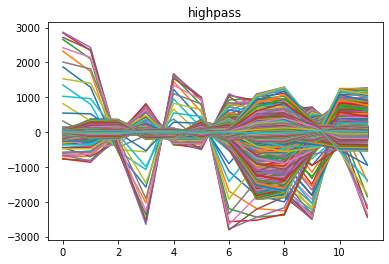

threshold:0.1
left: [  78  369  750 1089 1410 1674 1958 2259 2555] right: [ 125  458  791 1133 1453 1719 2001 2303 2601]
Q locations: [  86  398  753 1094 1415 1681 1963 2264 2562]
R locations: [ 101  436  769 1110 1431 1696 1979 2280 2577]
S locations: [ 115  451  784 1125 1445 1711 1994 2295 2592]


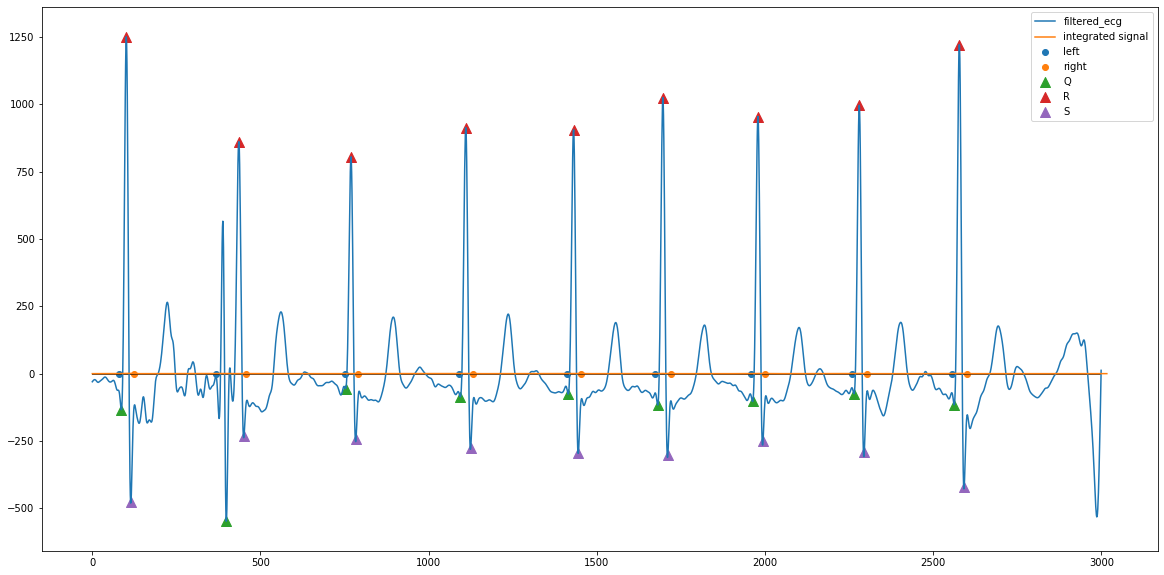

Q_loc: [  86  398  753 1094 1415 1681 1963 2264 2562] R_loc: [ 101  436  769 1110 1431 1696 1979 2280 2577] S_loc: [ 115  451  784 1125 1445 1711 1994 2295 2592] T_start_loc: [ 196  539  873 1214 1534 1796 2077 2380 2668]
T_peak_bound 263
T_peak_loc 248
T_end_loc 248
T_peak_bound 610
T_peak_loc 589
T_end_loc 589
T_peak_bound 946
T_peak_loc 932
T_end_loc 932
T_peak_bound 1281
T_peak_loc 1275
T_end_loc 1275
T_peak_bound 1583
T_peak_loc 1414
T_end_loc 1414
T_peak_bound 1851
T_peak_loc 1850
T_end_loc 1850
T_peak_bound 2139
T_peak_loc 2127
T_end_loc 2127
T_peak_bound 2440
T_peak_loc 2437
T_end_loc 2437


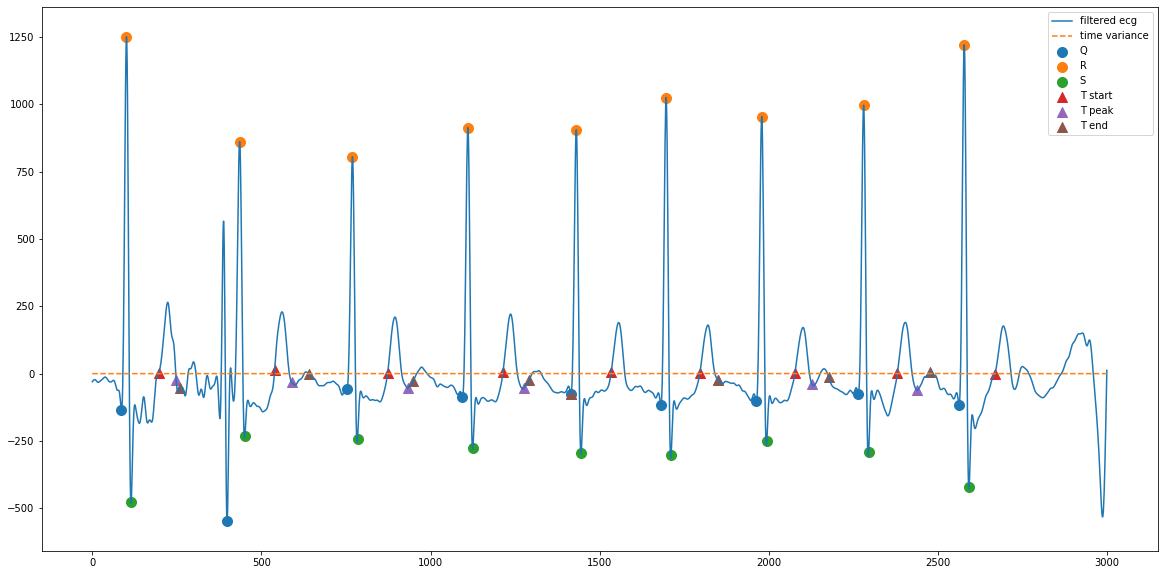

In [236]:
def despike(signal, window=20):
    threshold=np.std(signal)*4
    signal_copy = np.copy(signal)
    for i in range(len(signal)-window):
        if np.max(signal_copy[i:i+window]) - np.min(signal_copy[i:i+window]) > threshold:
            #print("yes")
            #signal_copy[i:i+window] = np.linspace(signal[i], signal[i+window], window)
            signal_copy[i:i+window] = im.median_filter(signal_copy[i:i+window], len(signal_copy[i:i+window]))   
    return signal_copy

import matplotlib.pyplot as plt
idx = 7000
lead = 2

signal_ans = myfilter(Datas[idx][:,1500:4500], fs=500.0)
_=extract_QRST(signal_ans)

(50.78125, 4.0625)


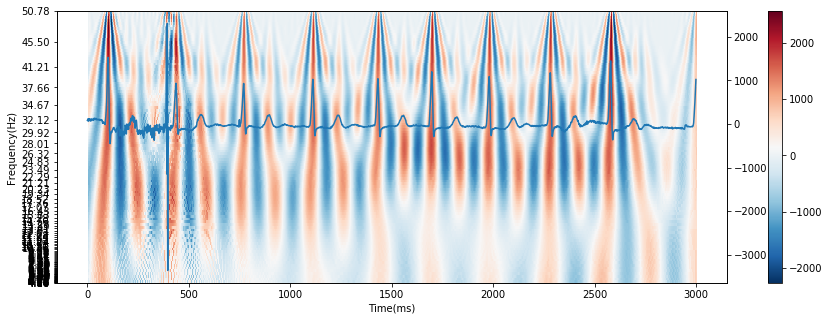

AFL


In [294]:
idx = 7000
_=cwt(Datas[idx][10,1500:4500], vis=True)
codes = get_classes_from_header(Header_datas[idx])
abbrs = ' '.join([get_abbr(int(code)) for code in codes])
print(abbrs)

(50.78125, 4.0625)


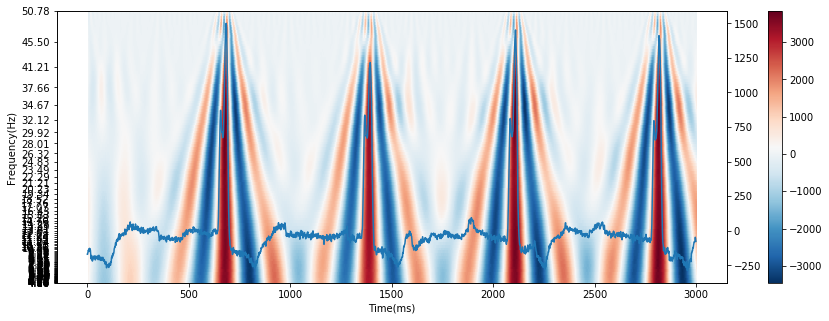

*ILBBB *CHB Brady *NSSTTA


In [297]:
idx = 7003
_=cwt(Datas[idx][10,1500:4500], vis=True)
codes = get_classes_from_header(Header_datas[idx])
abbrs = ' '.join([get_abbr(int(code)) for code in codes])
print(abbrs)

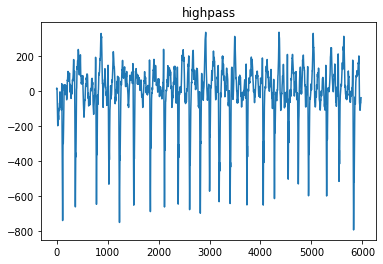

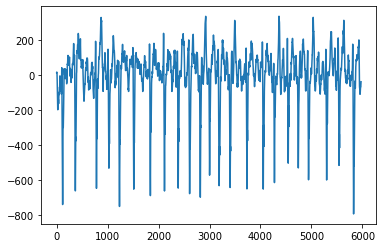

BadSignalWarning: 
----------------
Could not determine best fit for given signal. Please check the source signal.
 Probable causes:
- detected heart rate falls outside of bpmmin<->bpmmax constraints
- no detectable heart rate present in signal
- very noisy signal (consider filtering and scaling)
If you're sure the signal contains heartrate data, consider filtering and/or scaling first.
----------------


In [98]:
import matplotlib.pyplot as plt
for data in Datas[:1]:
    v1 = data[6,:]
    v1_filtered = myfilter(v1, fs=500)
    plt.plot(v1_filtered)
    plt.show()
    working_data, measures = hp.process(v1, 500.0)
    


In [229]:
Header_datas[7001]

['Q0128 12 500 18135 15-May-2020 15:35:30\n',
 'Q0128.mat 16+24 1000/mV 16 0 -28 11 0 I\n',
 'Q0128.mat 16+24 1000/mV 16 0 5 5 0 II\n',
 'Q0128.mat 16+24 1000/mV 16 0 33 14 0 III\n',
 'Q0128.mat 16+24 1000/mV 16 0 11 18 0 aVR\n',
 'Q0128.mat 16+24 1000/mV 16 0 -30 71 0 aVL\n',
 'Q0128.mat 16+24 1000/mV 16 0 19 65 0 aVF\n',
 'Q0128.mat 16+24 1000/mV 16 0 13 34 0 V1\n',
 'Q0128.mat 16+24 1000/mV 16 0 130 18 0 V2\n',
 'Q0128.mat 16+24 1000/mV 16 0 39 7 0 V3\n',
 'Q0128.mat 16+24 1000/mV 16 0 83 30 0 V4\n',
 'Q0128.mat 16+24 1000/mV 16 0 -39 -2 0 V5\n',
 'Q0128.mat 16+24 1000/mV 16 0 -33 -46 0 V6\n',
 '#Age: 62\n',
 '#Sex: Female\n',
 '#Dx: 427172004,428750005\n',
 '#Rx: Unknown\n',
 '#Hx: Unknown\n',
 '#Sx: Unknown\n']

In [99]:
v1_filtered2 = hp.enhance_ecg_peaks(hp.scale_data(v1), 500, 
                                aggregation='median', iterations=5)



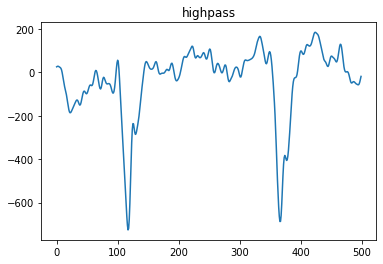

In [94]:
_=myfilter(v1[:500], 500)


In [101]:
working_data, measures = hp.process(hp.scale_data(v1), 500.0)

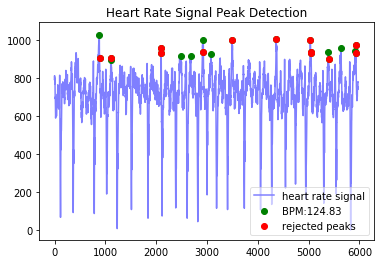

In [102]:
hp.plotter(working_data, measures)